# Aufgabe 08 - Temporal Fusion Transformer with SP 500
01.01.2022, Thomas Iten

**Content**
1. **Load data (with SP500 data module slightly adapted for time series support)**
2. Extact feature columns
3. Create TimeSeriesDataSet
4. **Create baseline model and train**
5. Train the Temporal Fusion Transformer
6. Train the model
7. Evaluate model performance with validation data
8. **Evaluate model performance with test data**

**References**
- https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html
- https://www.kaggle.com/utathya/future-volume-prediction

## 0. Setup

In [1]:
#
# Imports
#

import os, os.path, requests, datetime
import numpy as np
import pandas as pd
import bs4 as bs
import yfinance
import warnings
import copy
from pathlib import Path

import torch
import pytorch_lightning as pl
import tensorflow as tf
import tensorboard as tb
import datetime
#from datetime import datetime
from typing import Optional

from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.models.rnn import RecurrentNetwork

#
# Settings
#
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
warnings.filterwarnings("ignore")                       # avoid printing out absolute paths


## 1. Load data (with SP500 data module slightly adapted for time series support)

### Define data loader

In [2]:
class SP500DataModule(pl.LightningDataModule):
    """Data module for the 'Standard and Poor 500' company performance data, adapted for time series support.

    NOTE:
    To support the TFT task, the time_series flag has be introduced. By enabling this option,
    the data will be enhanced with the a time index and group flag, to support the TimeSeriesDataSet format.
    """

    URL = "http://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

    def __init__(self,
                 batch_size=32,
                 train_val_test_split=[80,10,10],
                 spy_binary=True,
                 time_series=False,
                 path=".",
                 force_download=False):
        super().__init__()
        # download properties
        self.start = datetime.datetime(2010, 1, 1)
        self.end = datetime.datetime.now()
        self.fname = path + "/sp500.csv"
        self.force_download = force_download
        # prepare and transform properties
        self.spy_binary = spy_binary
        self.time_series = time_series
        self.batch_size = batch_size
        self.train_val_test_split = train_val_test_split
        # data
        self.data = None
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

    def prepare_data(self):
        """Download and prepare the SP500 data."""
        df = self._download_sp500()
        if self.spy_binary:
            df.SPY = [1 if spy > 0 else 0 for spy in df.SPY]
        self.data = df

    def setup(self, stage: Optional[str] = None):
        """Setup the data according the stage 'fit' or 'test'. If the stage is none, setup the data for all stages."""

        # Split data into test, val and train dataframes
        train_percent, val_percent, test_percent = self.train_val_test_split
        rows = self.data.shape[0]
        test_rows = int(test_percent * rows / 100)
        val_rows = int(val_percent * rows / 100)
        train_rows =  rows - test_rows - val_rows

        print("Setup - define data split:")
        print("- Train rows : {0:04d} ( {1}%)".format(train_rows, train_percent))
        print("- Val   rows : {0:04d} ( {1}%)".format(val_rows, val_percent))
        print("- Test  rows : {0:04d} ( {1}%)".format(test_rows, test_percent))
        print("- Total rows : {0:04d} (100%)".format(rows))

        print("Setup - split and transform data for stage: {}".format(stage))
        if stage == "fit" or stage is None:
            train_data = self.data.iloc[:train_rows]
            val_data = self.data.iloc[train_rows:train_rows+val_rows]
            print("- Train shape: {}".format(train_data.shape))
            print("- Val   shape: {}".format(val_data.shape))
            # transform data and assign properties to use in data loaders
            self.train_dataset = self._transform(train_data)
            self.val_dataset = self._transform(val_data)
        if stage == "test" or stage is None:
            test_data = self.data.iloc[train_rows+val_rows:]
            print("- Test  shape: {}".format(test_data.shape))
            # transform data and assign properties to use in data loaders
            self.test_dataset = self._transform(test_data)
        print("- Total shape: {}".format(self.data.shape))


    def size(self):
        return self.train_dataloader().dataset.tensors[0].data.shape[1]

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

    def _transform(self, df):
        if self.time_series:
            return self._transform_to_timeseries_df(df)
        return self._transform_to_dataset(df)

    def _transform_to_timeseries_df(self, df):
        # create time index
        df['date'] = df.index.to_pydatetime()
        df["time_idx"] = df["date"].dt.year * 12 * 31 + df["date"].dt.month * 31 + df["date"].dt.day
        df["time_idx"] -= int(df["time_idx"].min())
        # create group (At least one groupt is used for the TimeSeriesDataSet)
        df['group_id'] = 0
        # return result
        return df

    def _transform_to_dataset(self, df):
        # Split labels and features
        labels = df.SPY.values
        features = df.iloc[:, :-1].values
        # Convert to tensor
        tensor_labels   = torch.tensor(labels).unsqueeze(1).float()
        tensor_features = torch.tensor(features).float()
        # Create tensor dataset
        return TensorDataset(tensor_features, tensor_labels)

    def _download_sp500(self) -> pd.DataFrame:
        """Download the SP500 data from the internet, save data to a csv file and return the result.

        Notes:
        - All further calls will serve the data from the csv file.
        - To trigger a new download from the internet, set the force_download flag to True.
        """

        # Load data from file
        if os.path.isfile(self.fname) and not self.force_download:
            print("Load SP500 from file:", self.fname)
            return pd.read_csv(self.fname, index_col=0, parse_dates=True)

        # Download data
        print("Download data from:", SP500DataModule.URL)
        resp = requests.get(SP500DataModule.URL)
        soup = bs.BeautifulSoup(resp.text, 'lxml')
        table = soup.find('table', {'class': 'wikitable sortable'})

        tickers = []
        for row in table.findAll('tr')[1:]:
            ticker = row.findAll('td')[0].text
            tickers.append(ticker)

        tickers = [s.replace('\n', '') for s in tickers]
        data = yfinance.download(tickers, start=self.start, end=self.end)
        df_data = data['Adj Close']

        df_spy = yfinance.download("SPY", start=self.start, end=self.end)
        df_spy = df_spy.loc[:, ['Adj Close']]
        df_spy.columns = ['SPY']

        df = pd.concat([df_data, df_spy], axis=1)

        # Prepare data
        df.dropna(axis=0, how='all', inplace=True)
        print("Dropping columns due to nans > 50%:", df.loc[:, list((100 * (df.isnull().sum() / len(df.index)) > 50))].columns)
        df = df.drop(df.loc[:, list((100 * (df.isnull().sum() / len(df.index)) > 50))].columns, 1)
        df = df.ffill().bfill()
        print("Any columns still contain nans:", df.isnull().values.any())

        df_returns = pd.DataFrame()
        for name in df.columns:
            df_returns[name] = np.log(df[name]).diff()

        df_returns.dropna(axis=0, how='any', inplace=True)

        # Save data and return result
        print("Save data to file:", self.fname)
        df_returns.to_csv(self.fname)

        self.data = df_returns
        return self.data


### Load data

In [3]:
dm = SP500DataModule(spy_binary=False, time_series=True)
dm.prepare_data()
dm.setup()

data = dm.train_dataset

print("Data Type:")
print(type(data))

print("Data")
data.head()

Load SP500 from file: ./sp500.csv
Setup - define data split:
- Train rows : 2392 ( 80%)
- Val   rows : 0299 ( 10%)
- Test  rows : 0299 ( 10%)
- Total rows : 2990 (100%)
Setup - split and transform data for stage: None
- Train shape: (2392, 490)
- Val   shape: (299, 490)
- Test  shape: (299, 490)
- Total shape: (2990, 490)
Data Type:
<class 'pandas.core.frame.DataFrame'>
Data


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XYL,YUM,ZBH,ZBRA,ZION,ZTS,SPY,date,time_idx,group_id
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0.007375,-0.014569,-0.002473,0.015445,0.0,0.021253,0.001145,0.008668,0.013641,0.008393,...,0.0,0.003426,0.015278,0.011224,0.038231,0.0,0.016817,2010-01-04,0,0
2010-01-05,-0.010922,0.107246,-0.005962,0.001727,0.0,-0.007160,-0.024321,-0.008112,0.006162,0.016313,...,0.0,-0.003426,0.031165,-0.001745,0.034651,0.0,0.002644,2010-01-05,1,0
2010-01-06,-0.003559,-0.042314,0.008682,-0.016034,0.0,-0.009501,-0.015358,0.005539,0.010574,-0.002124,...,0.0,-0.007174,-0.000323,-0.007717,0.083382,0.0,0.000704,2010-01-06,2,0
2010-01-07,-0.001297,0.029044,-0.000247,-0.001850,0.0,-0.016166,0.000000,0.008250,-0.000935,-0.019595,...,0.0,-0.000288,0.022681,-0.025318,0.106160,0.0,0.004212,2010-01-07,3,0
2010-01-08,-0.000325,-0.019268,0.003945,0.006626,0.0,0.010807,-0.020446,0.005099,-0.003986,-0.005436,...,0.0,0.000288,-0.021228,-0.003256,-0.016320,0.0,0.003322,2010-01-08,4,0


## 2. Extact feature columns

In [4]:
features_columns = list(data.columns.values[:-4])
print(features_columns, sep="")


['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BAC', 'BAX', 'BBWI', 'BBY', 'BDX', 'BEN', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLK', 'BLL', 'BMY', 'BR', 'BRO', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE', 'CERN', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CRL', 'CRM', 'CSCO', 'CSX', 'CTAS', 'CTLT', 'CTRA', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DISCA', 'DISCK', 'DISH', 'DLR', 'DLTR', 'DOV', 'DPZ', 'DRE',

## 3. Create TimeSeriesDataSet

In [5]:
# Max. number of timesteps for prediction
max_prediction_length = 6

# Max. number of timesteps for training
max_encoder_length    = 24

# Training cutoff: total - perdiction,
training_cutoff = data["time_idx"].max() - max_prediction_length

def create_time_series_data_set(data):
    return TimeSeriesDataSet(
        data[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",                            # Zeit Index
        group_ids=["group_id"],
        target="SPY",
        # group_ids=["agency", "sku"],                  # Preprocessing: Normaliserung und Encoding je Gruppe.
                                                    # Es kann variert werden zwischen min und max
        min_encoder_length=max_encoder_length // 2,     # Keep encoder length long (as it is in the validation set)
        max_encoder_length=max_encoder_length,          #

        min_prediction_length=1,                        # Er kann auch weniger TimeSteps prediction, wenn zu wenig Daten vorhanden sind
        max_prediction_length=max_prediction_length,

        # statics
        # static_categoricals=["agency", "sku"],
        # static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],

        # time varying known (Planwerte) (es wird ein LSTM je Kategorie gebaut und verwendet)
        # time_varying_known_categoricals=["special_days", "month"],  # known (Plan Werte)
        # variable_groups={"special_days": special_days},             # group of categorical variables can be treated as one variable

        # time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
        time_varying_known_reals=["time_idx"],

        # time varying unknown (es wird ein LSTM je Kategorie gebaut und verwendet)
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=features_columns,

        # target_normalizer=GroupNormalizer(                          # TODO ti: auskommentiern wenn log target verwendet wird
        #     groups=["agency", "sku"], transformation="softplus"     # Use softplus and normalize by group
        # ),                                                          # Normalisieurung 8 -> 1,22 zurück 8.5 != exp(8)

        # variablen die zusätzlich erstellt werden durch netzwerk
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
        allow_missing_timesteps=True
)

training = create_time_series_data_set(data)

# Create validation set (predict=True)
# Which means to predict the last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)


# create dataloaders for model
batch_size = 128  # set this between 32 to 128

# create data loaders
train_dataloader = training.to_dataloader  (train=True,  batch_size=batch_size, num_workers=0)
val_dataloader   = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


To learn more about the :py:class:`~pytorch_forecasting.data.timeseries.TimeSeriesDataSet`, visit its documentation or the :ref:`tutorial explaining how to pass datasets to models <passing-data>`.

## 4. Create baseline model

In [6]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history

actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

0.003061520168557763

## 5. Train the Temporal Fusion Transformer

### Find optimal learning rate

Prior to training, you can identify the optimal learning rate with the [PyTorch Lightning learning rate finder](https://pytorch-lightning.readthedocs.io/en/latest/lr_finder.html).

In [7]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,            # Guter Bereich: 0.01 ... 0.03 / RangerOptimzer ist Top
    hidden_size=16,                # most important hyperparameter apart from learning rate
    attention_head_size=1,         # number of attention heads. Set to up to 4 for large datasets
    dropout=0.1,                   # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,      # set to <= hidden_size
    output_size=7,                 # 7 quantiles by default
    loss=QuantileLoss(),           # Quantile loss für quantile predictions
    reduce_on_plateau_patience=4,  # reduce learning rate if no improvement in validation loss after x epochs
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 358.9k


Global seed set to 42


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at D:\dev\workspace\surfmachine\ai\src\08_tft\lr_find_temp_model_342839e7-3f72-4c19-b5b9-e16487619cb9.ckpt


suggested learning rate: 0.07943282347242808


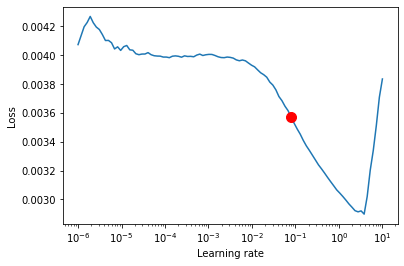

In [8]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

## 6. Train the model

In [9]:
# configure network and trainer
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=10,            # Abbruch wenn 10x nicht verbessert
    verbose=False,
    mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=1, # 30
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # !! Zeigt Feature Importance und weiteres! comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 358.9k


Training takes a couple of minutes on my Macbook but for larger networks and datasets, it can take hours. The training speed is here mostly determined by overhead and choosing a larger `batch_size` or `hidden_size` (i.e. network size) does not slow does training linearly making training on large datasets feasible. During training, we can monitor the tensorboard which can be spun up with `tensorboard --logdir=lightning_logs`. For example, we can monitor examples predictions on the training and validation set.

In [10]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 7.9 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 341 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Hyperparameter tuning

## 7. Evaluate model performance with validation data


### Load best tft
PyTorch Lightning automatically checkpoints training and thus, we can easily retrieve the best model and load it.

In [11]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)


### Calcualte mean absolute error on validation set

After training, we can make predictions with :py:meth:`~pytorch_forecasting.models.base_model.BaseModel.predict`.
- The method allows very fine-grained control over what it returns so that, for example, you can easily match
  predictions to your pandas dataframe.
- See its documentation for details.

In [12]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.0067)

## 8. Evaluate model performance with test data

### Create test data loader

In [13]:
test_data = dm.test_dataset
ts = create_time_series_data_set(test_data)
test = TimeSeriesDataSet.from_dataset(ts, test_data, predict=True, stop_randomization=True)
test_dataloader  = test.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

### Calcualte mean absolute error on test set


In [14]:
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = best_tft.predict(test_dataloader)
(actuals - predictions).abs().mean()


tensor(0.0056)

_The end._